# Validating Strawberry Puree via Infrared Spectral Analysis

<br>
<br>

The purpose of this analysis is to classify strawberry puree as "pure" or "not-pure" by analyzing the frequency domain in the mid-infrared spectrum using Attenuated Total Reflectance sampling.  Not-pure samples have been adulterated with other fruit purees.  

Spectral analysis is a common practice in analyzing fruit and vegetables.  Here, we use a back prop network with 5 hidden layers.

<br>
<br>

~~The Input Layer is made up of 235 nodes.  Each input node represents the strength of a specific wavenumber

~~Hidden Layers 1 and 5 have 1000 ReLU nodes

~~Hidden Layers 2,3 and 4 have 10000

~~The Output Layer is made up of 2 nodes representing unadulerated strawberry puree or the adulterated version.

<br>
<br>
<br>

The data used in this notebook came from an original analysis by Holland, Kemsley and Wilson.

<i>"Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees" Holland JK, Kemsley EK, Wilson RH. (1998). Journal of the Science of Food and Agriculture, 76, 263-269</i>

Abstract and Full-text (paywall) are available here: https://europepmc.org/article/agr/ind21806286

The dataset was downloaded from: http://www.timeseriesclassification.com/description.php?Dataset=Strawberry

<br>
<br>
<br>


## Side note:

I deliberately threw the bus at the problem.  There is no need  for so many dense layers.  There is no need to 80 epochs of training.  This was just a feasibility study and needs to be cleaned up.

<br>
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

plt.style.use('dark_background')


In [2]:
df = pd.read_csv('MIR_Fruit_purees.csv')
df.head()

,Wavenumbers,NON-Strawberry,NON-Strawberry.1,NON-Strawberry.2,NON-Strawberry.3,NON-Strawberry.4,NON-Strawberry.5,NON-Strawberry.6,NON-Strawberry.7,NON-Strawberry.8,...,NON-Strawberry.622,NON-Strawberry.623,NON-Strawberry.624,NON-Strawberry.625,NON-Strawberry.626,NON-Strawberry.627,NON-Strawberry.628,NON-Strawberry.629,NON-Strawberry.630,NON-Strawberry.631
0,899.327,0.002806,0.002637,0.002416,0.002345,0.002303,0.002514,0.002105,0.002018,0.002154,...,0.002539,0.002569,0.002723,0.002542,0.002627,0.002631,0.002730,0.002713,0.002697,0.002789
1,903.187,0.002732,0.002638,0.002480,0.002292,0.002342,0.002488,0.002078,0.001999,0.002165,...,0.002507,0.002569,0.002714,0.002539,0.002629,0.002651,0.002839,0.002779,0.002905,0.003040
2,907.047,0.002661,0.002651,0.002511,0.002249,0.002350,0.002477,0.002077,0.001945,0.002191,...,0.002483,0.002541,0.002740,0.002574,0.002619,0.002696,0.002999,0.002877,0.003277,0.003359
3,910.907,0.002657,0.002757,0.002611,0.002303,0.002419,0.002542,0.002154,0.001964,0.002275,...,0.002563,0.002599,0.002861,0.002664,0.002714,0.002809,0.003259,0.003085,0.003711,0.003796
4,914.767,0.002699,0.003000,0.002802,0.002466,0.002561,0.002713,0.002311,0.002083,0.002470,...,0.002764,0.002806,0.003090,0.002829,0.002939,0.003022,0.003649,0.003419,0.004265,0.004394


<br>
<br>

# Data Wrangling

### Isolate Wavenumbers from the dataframe

In [3]:
# isolate the wavenumbers into a new variable
wavenumbers = df.iloc[:,0]

In [4]:
# remove "Wavenumbers" from the original df prior to Transposing
df.drop(labels='Wavenumbers', axis=1, inplace=True)

<br>

### Transpose the dataframe, and rename the output variable

In [5]:
# Transpose the df and reset index, then rename the old index
df = df.T
df = df.reset_index()
df = df.rename(columns={'index': 'Outcome'})

# shuffle the df so Outcome is at the end 
df = df.iloc[:,1:].join(df.iloc[:,0])

<br>

### Rename the Columns as Wavenumbers

In [6]:
# convert the wavenumbers to columns and round them down to 3 decimal places
cols = [ round(f, 3) for f in wavenumbers.to_list() ]

# add the final column name 'Outcome' to the list and set the df columns 
cols.append('Outcome')
df.columns = cols

# sort the df by Outcome and reset index
df = df.sort_values('Outcome').reset_index(drop=True)

df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry.1
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,NON-Strawberry.10
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,NON-Strawberry.100
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,NON-Strawberry.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,Strawberry.95
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,Strawberry.96
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,Strawberry.97
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,Strawberry.98


<br>
<br>

### Convert the Dependent Variable to True or False values

Binary classification problem

In [7]:
# replace NON Strawberry outcomes with False
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^NON.*$', value=False, regex=True)

# replace Strawberry with True
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^Straw.*$', value=True, regex=True)

In [8]:
df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,False
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,False
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,False
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,False
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,True
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,True
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,True
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,True


<br>
<br>
<br>

# EDA on the Spectra

### Plot wavenumbers for Strawberry == True

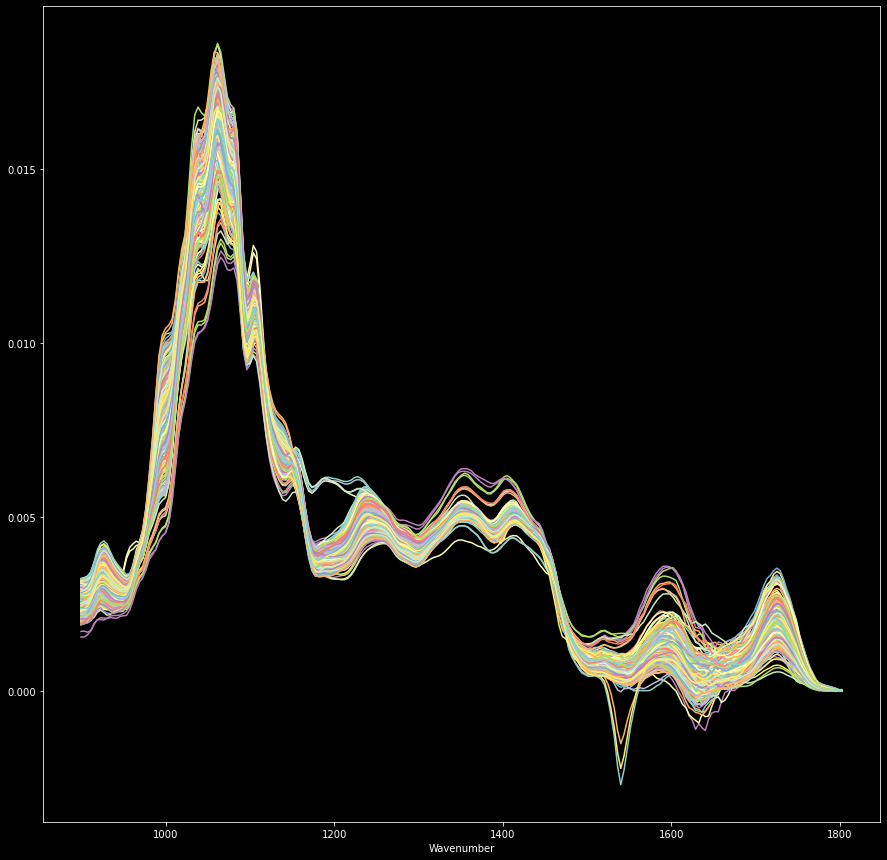

In [9]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(df.query('Outcome == True').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Plot wavenumbers for Strawberry == False

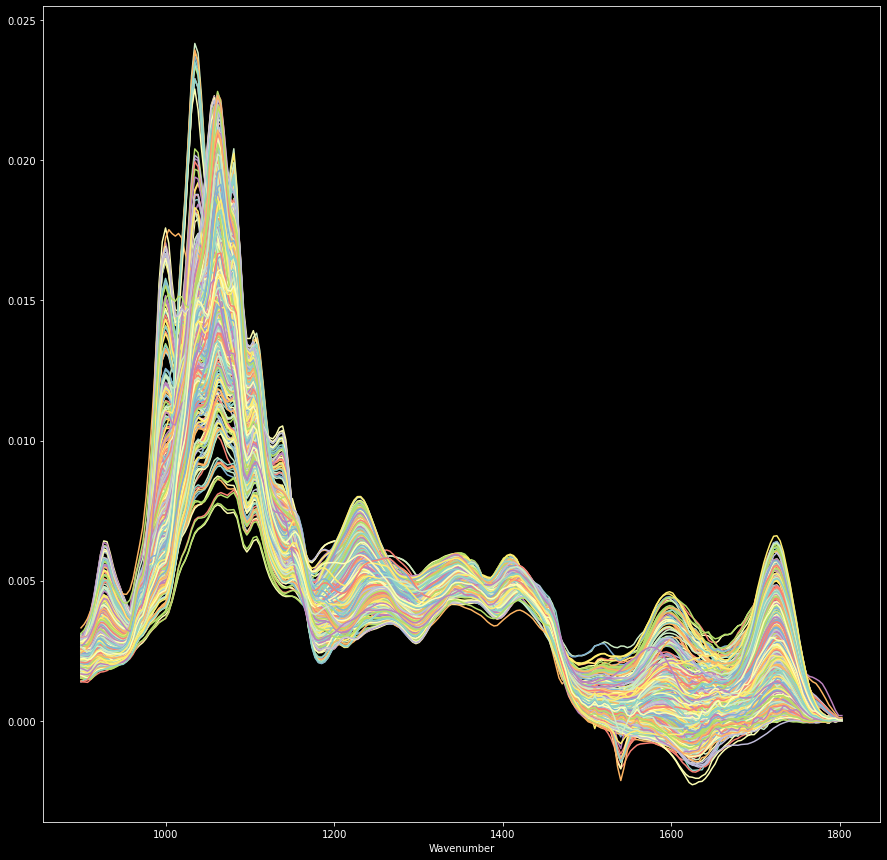

In [10]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(15,15))
plt.plot(df.query('Outcome == False').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Split the Data into Training and Validation Sets

In [11]:
# subset 30% of the dataframe to make up the validation set
dfv = df.sample(frac=0.3, replace=False, random_state=4)

# assign the rest as the training set
dft = df.drop(dfv.index)

In [12]:
dfv

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
646,0.002404,0.002398,0.002409,0.002521,0.002737,0.002956,0.003066,0.003046,0.002999,0.002907,...,0.000154,0.000091,0.000059,0.000035,0.000020,0.000012,0.000007,0.000006,0.000006,True
845,0.002839,0.002861,0.002887,0.002994,0.003205,0.003479,0.003681,0.003714,0.003616,0.003456,...,0.000199,0.000121,0.000074,0.000048,0.000029,0.000025,0.000020,0.000012,0.000012,True
595,0.002165,0.002127,0.002086,0.002109,0.002228,0.002341,0.002348,0.002290,0.002262,0.002249,...,0.000409,0.000267,0.000178,0.000120,0.000080,0.000057,0.000036,0.000018,0.000018,False
747,0.002406,0.002475,0.002517,0.002631,0.002859,0.003104,0.003243,0.003240,0.003182,0.003091,...,0.000130,0.000075,0.000048,0.000030,0.000018,0.000016,0.000010,0.000005,0.000005,True
260,0.002639,0.002678,0.002726,0.002822,0.003021,0.003297,0.003508,0.003565,0.003497,0.003370,...,0.000187,0.000118,0.000087,0.000059,0.000045,0.000030,0.000009,0.000005,0.000005,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,0.001695,0.001755,0.001754,0.001793,0.001993,0.002244,0.002446,0.002490,0.002408,0.002370,...,0.000375,0.000230,0.000157,0.000104,0.000063,0.000037,0.000020,0.000007,0.000007,False
282,0.002305,0.002254,0.002214,0.002250,0.002360,0.002481,0.002487,0.002397,0.002320,0.002294,...,0.000256,0.000224,0.000207,0.000186,0.000156,0.000127,0.000078,0.000036,0.000036,False
880,0.002104,0.002094,0.002133,0.002264,0.002494,0.002755,0.002917,0.002911,0.002823,0.002751,...,0.000236,0.000143,0.000093,0.000059,0.000040,0.000023,0.000011,0.000007,0.000007,True
728,0.002323,0.002343,0.002349,0.002456,0.002633,0.002789,0.002844,0.002805,0.002725,0.002635,...,0.000166,0.000091,0.000056,0.000034,0.000024,0.000022,0.000016,0.000011,0.000011,True


In [13]:
dft

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,False
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,False
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,False
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,False
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,0.002396,0.002426,0.002487,0.002612,0.002856,0.003122,0.003237,0.003219,0.003153,0.003056,...,0.000096,0.000043,0.000029,0.000016,0.000014,0.000015,0.000008,0.000009,0.000009,True
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,True
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,True
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,True


<br>
<br>

## ~~Normalize the data~~

In [14]:
# Find the maximum value of all the independent variables in the Training Set
maxval = dft.iloc[:, :-1].max().max()  # max of each column , then max of all columns
maxval

0.024165717000000003

In [15]:
# Normalize the training set against the maxval and add the output variable back in
dft_norm = dft.iloc[:, :-1] / maxval
dft_norm = dft_norm.join(dft.iloc[:, -1])

dft_norm

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.116095,0.113050,0.110121,0.109952,0.111674,0.114291,0.113745,0.111142,0.109116,0.108278,...,0.014385,0.008936,0.006874,0.004825,0.003602,0.001897,0.000448,0.000389,0.000389,False
1,0.109137,0.109177,0.109717,0.114103,0.124145,0.137101,0.141211,0.136633,0.130845,0.126608,...,0.000542,0.000245,-0.000205,-0.000227,-0.000228,0.000076,0.000400,0.000210,0.000210,False
2,0.085014,0.084380,0.084009,0.085914,0.091110,0.097231,0.099639,0.097346,0.094183,0.094072,...,0.019303,0.012180,0.007930,0.005181,0.003179,0.002217,0.001461,0.000577,0.000577,False
3,0.096418,0.096503,0.094788,0.096335,0.102698,0.109224,0.109848,0.105715,0.102097,0.100474,...,0.013952,0.009047,0.004582,0.002938,0.001013,0.002144,0.002538,0.000757,0.000757,False
4,0.106003,0.106153,0.106926,0.111340,0.119438,0.128806,0.133791,0.134032,0.131528,0.127335,...,0.012687,0.008229,0.005197,0.003384,0.002113,0.001682,0.001217,0.000389,0.000389,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,0.099153,0.100376,0.102918,0.108071,0.118186,0.129186,0.133939,0.133189,0.130490,0.126440,...,0.003966,0.001776,0.001201,0.000664,0.000592,0.000638,0.000316,0.000356,0.000356,True
978,0.087867,0.090485,0.091291,0.091303,0.097282,0.106121,0.110388,0.107491,0.105920,0.103750,...,0.010491,0.006260,0.003980,0.002727,0.001780,0.001565,0.001512,0.000585,0.000585,True
980,0.101350,0.103420,0.103688,0.109947,0.120502,0.129823,0.136991,0.137566,0.133121,0.127655,...,0.004275,0.002350,0.001448,0.000808,0.000661,0.000614,0.000368,0.000281,0.000281,True
981,0.094190,0.097595,0.100618,0.107292,0.117093,0.127821,0.134762,0.135956,0.134012,0.130051,...,0.007633,0.004229,0.002483,0.001318,0.000945,0.000773,0.000586,0.000537,0.000537,True


In [16]:
# Normalize the validation set against the maxval and add the output variable back in
# We use the same maxval of the training set to avoid peeking into the future
dfv_norm = dfv.iloc[:, :-1] / maxval
dfv_norm = dfv_norm.join(dfv.iloc[:, -1])

dfv_norm

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
646,0.099472,0.099236,0.099693,0.104302,0.113256,0.122303,0.126891,0.126063,0.124099,0.120307,...,0.006376,0.003763,0.002458,0.001446,0.000819,0.000503,0.000301,0.000232,0.000232,True
845,0.117462,0.118390,0.119451,0.123908,0.132607,0.143957,0.152341,0.153675,0.149641,0.143027,...,0.008216,0.005000,0.003055,0.001987,0.001210,0.001049,0.000816,0.000498,0.000498,True
595,0.089583,0.087997,0.086303,0.087286,0.092177,0.096882,0.097146,0.094755,0.093596,0.093076,...,0.016912,0.011042,0.007353,0.004961,0.003308,0.002342,0.001495,0.000731,0.000731,False
747,0.099571,0.102404,0.104145,0.108879,0.118294,0.128441,0.134196,0.134068,0.131662,0.127893,...,0.005368,0.003093,0.001991,0.001250,0.000760,0.000660,0.000423,0.000193,0.000193,True
260,0.109200,0.110818,0.112819,0.116774,0.124994,0.136451,0.145182,0.147536,0.144724,0.139434,...,0.007753,0.004876,0.003601,0.002440,0.001850,0.001223,0.000384,0.000188,0.000188,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,0.070149,0.072620,0.072602,0.074202,0.082460,0.092863,0.101205,0.103045,0.099662,0.098058,...,0.015520,0.009529,0.006516,0.004299,0.002589,0.001526,0.000828,0.000286,0.000286,False
282,0.095376,0.093291,0.091597,0.093115,0.097656,0.102683,0.102896,0.099186,0.095994,0.094927,...,0.010607,0.009262,0.008563,0.007689,0.006457,0.005238,0.003215,0.001474,0.001474,False
880,0.087065,0.086633,0.088252,0.093693,0.103214,0.113986,0.120724,0.120447,0.116837,0.113826,...,0.009760,0.005921,0.003857,0.002438,0.001658,0.000952,0.000475,0.000278,0.000278,True
728,0.096122,0.096966,0.097214,0.101635,0.108948,0.115425,0.117672,0.116079,0.112750,0.109035,...,0.006852,0.003752,0.002322,0.001424,0.000988,0.000913,0.000659,0.000457,0.000457,True


<br>
<br>

### Plot the Split and Normalized Data

#### Plot the Training Set where Strawberry == True

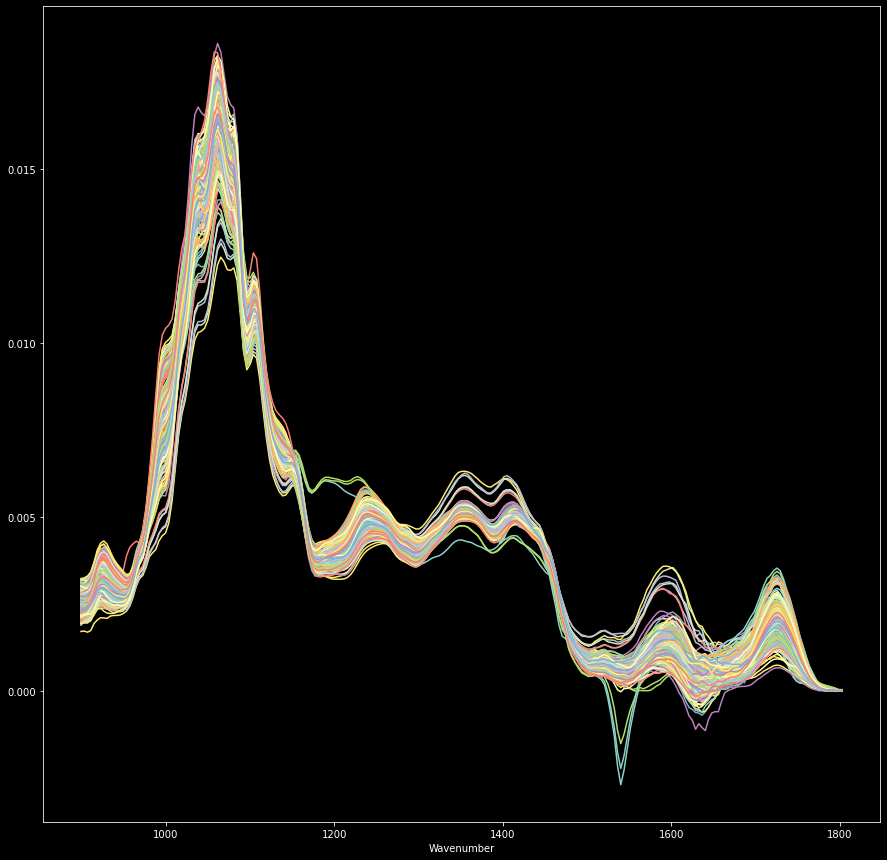

In [17]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(dft.query('Outcome == True').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Training Set where Strawberry == False

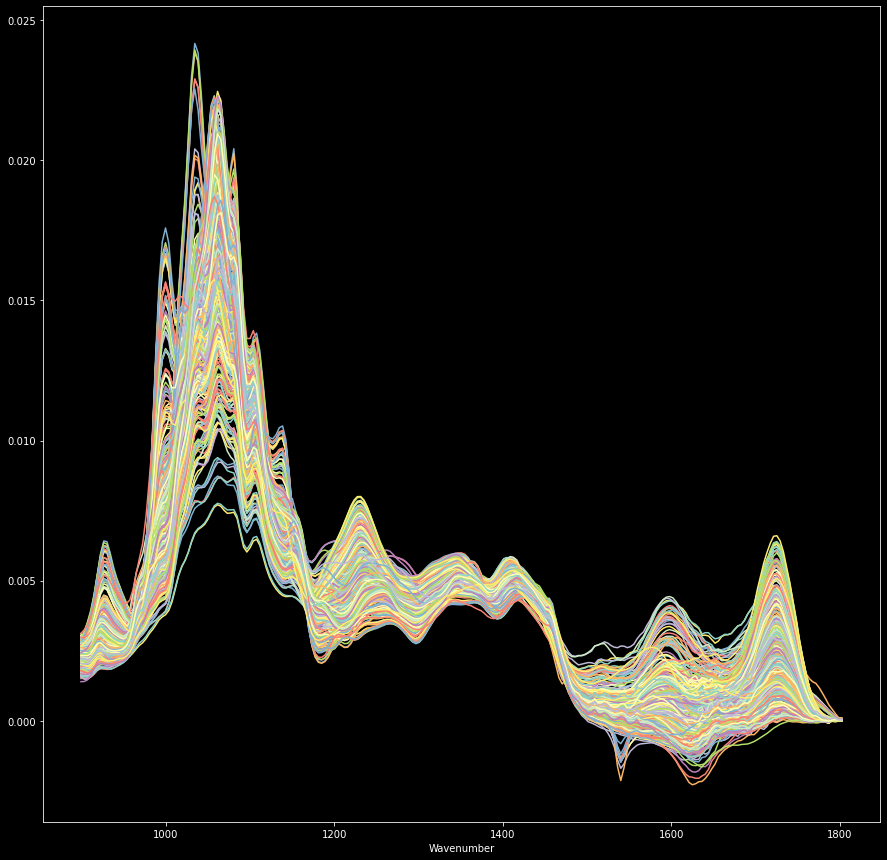

In [18]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(15,15))
plt.plot(dft.query('Outcome == False').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == True

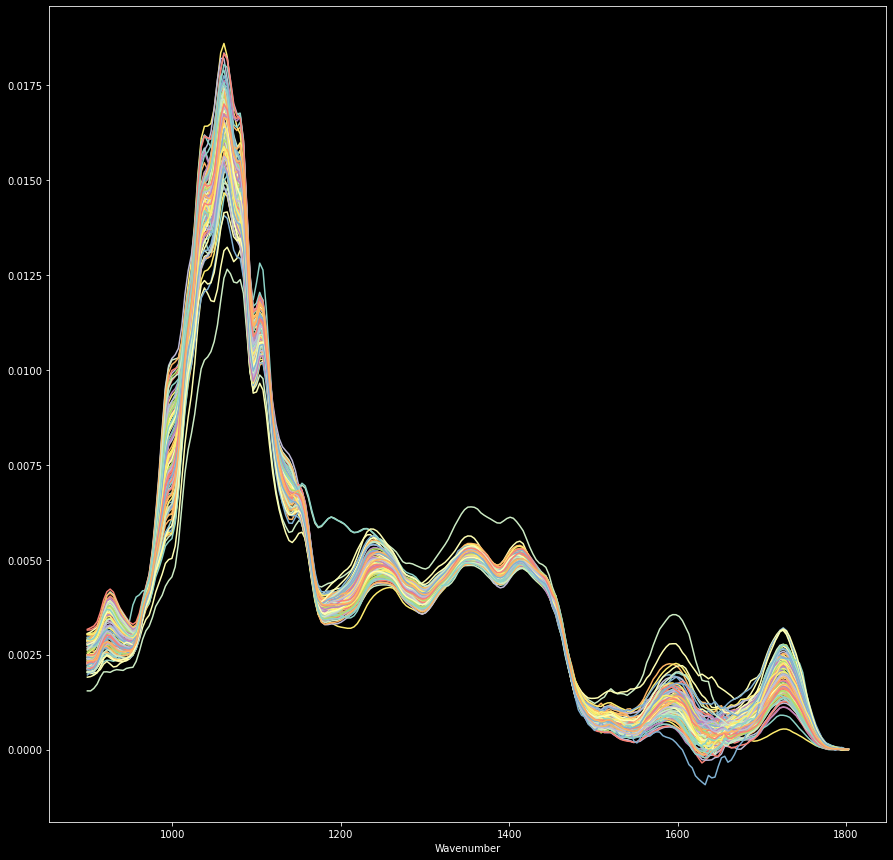

In [19]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(dfv.query('Outcome == True').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == False

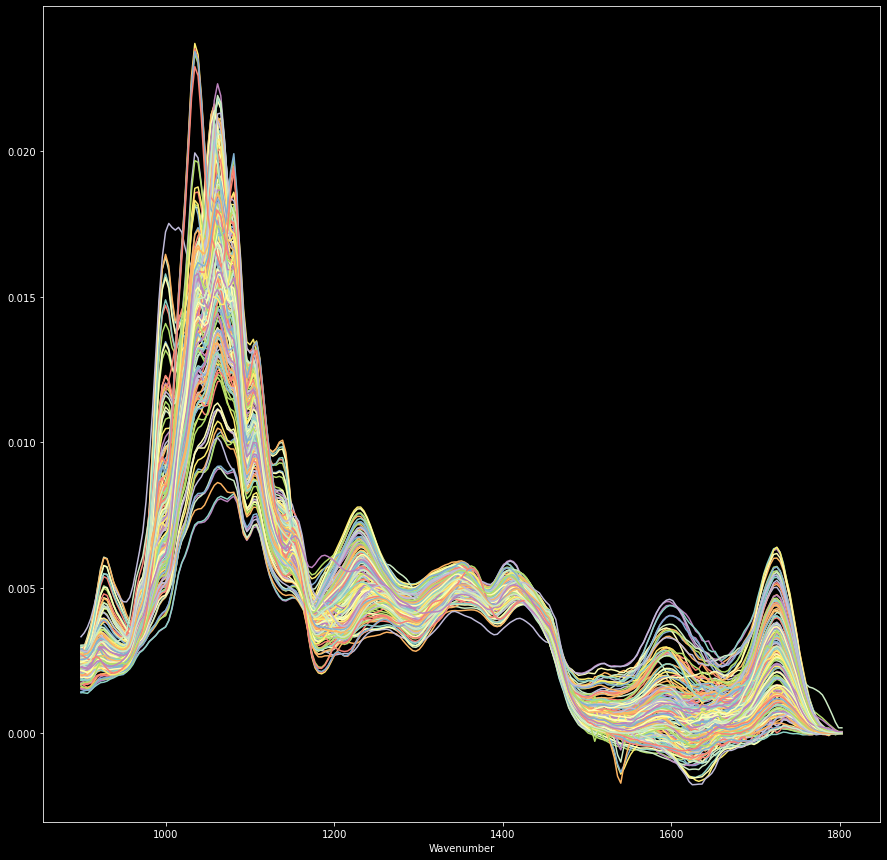

In [20]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(15,15))
plt.plot(dfv.query('Outcome == False').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>
<br>
<br>

# Analysis

### Define the Learner

In [139]:
from fastai.tabular.all import *

dls = TabularDataLoaders.from_df(dft, y_names=['Outcome'], procs = [Categorify, FillMissing, Normalize])
learn = tabular_learner(dls, lr=1e-3, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], layers=[1000,10000,10000,1000]) #, layers=[1000,10000,10000,10000,1000])


<br>
<br>

### ~~Define an Early Callback~~

In [140]:
# early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.1, patience=2)

<br>
<br>

## Fit the model

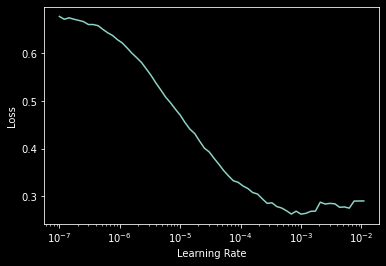

In [141]:
# plot the learning rates vs loss
lr_min,lr_steep = learn.lr_find()

In [142]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-04, steepest point: 3.31e-06


In [143]:
learn.fit_one_cycle(35)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.298677,0.469453,0.051095,0.948905,0.917647,0.886364,0.951220,00:05
1,0.196927,0.221412,0.072993,0.927007,0.891304,0.803922,1.000000,00:05
2,0.154506,0.088068,0.029197,0.970803,0.952381,0.930233,0.975610,00:05
3,0.149708,0.139723,0.043796,0.956204,0.931818,0.872340,1.000000,00:05
4,0.142435,0.797344,0.109489,0.890511,0.845361,0.732143,1.000000,00:05
5,0.136219,0.209417,0.043796,0.956204,0.930233,0.888889,0.975610,00:05
6,0.149303,0.908974,0.131387,0.868613,0.727273,0.960000,0.585366,00:05
7,0.190713,4.248222,0.233577,0.766423,0.719298,0.561644,1.000000,00:05
8,0.210319,0.181690,0.043796,0.956204,0.931818,0.872340,1.000000,00:05
9,0.203684,0.183088,0.080292,0.919708,0.881720,0.788462,1.000000,00:05


In [144]:
# learn.fine_tune(4)

<br>
<br>

### Visualize the Training Set Results


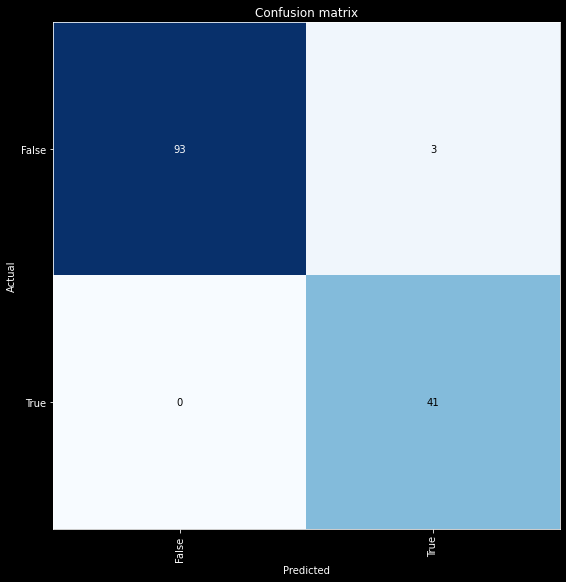

In [145]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

<br>
<br>
<br>

# Show Predictions

<br>

### Make a Random Prediction on an Item in the Validation Set

In [146]:
rown = 3
row = dfv.iloc[rown, :-1]

print(f'Actually a Strawberry:           {dfv.iloc[rown, -1]}')
print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[1]) }')
# print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[-1][1].item()) }')

Actually a Strawberry:           True


Predicted to be a Strawberry:    True


<br>
<br>
<br>

## Iteratively Predict Over the Entire Validation Set (Manually)

In [147]:
TP = 0
TN = 0
FP = 0
FN = 0

print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = dfv.iloc[i, -1]
    predicted = bool(learn.predict(row=dfv.iloc[i, :-1])[1].item())
    
    print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');

 idx    Actual   Predicted


   0    True     True


   1    True     True


   2    False    False


   3    True     True


   4    False    False


   5    False    False


   6    True     True


   7    True     True


   8    True     True


   9    True     True


  10    True     True


  11    False    False


  12    False    False


  13    False    False


  14    True     True


  15    False    False


  16    True     True


  17    True     True


  18    False    False


  19    False    False


  20    False    False


  21    False    False


  22    False    False


  23    False    False


  24    False    False


  25    True     True


  26    False    False


  27    False    False


  28    True     True


  29    True     True


  30    True     True


  31    False    False


  32    False    False


  33    False    False


  34    False    False


  35    True     True


  36    False    False


  37    False    False


  38    True     True


  39    True     True


  40    False    False


  41    False    False


  42    True     True


  43    True     True


  44    True     True


  45    False    False


  46    False    False


  47    True     False


  48    False    False


  49    False    False


  50    False    False


  51    False    False


  52    False    False


  53    True     True


  54    False    False


  55    True     True


  56    True     True


  57    True     False


  58    False    False


  59    True     True


  60    True     True


  61    False    False


  62    False    False


  63    True     True


  64    False    False


  65    False    False


  66    False    False


  67    False    False


  68    True     True


  69    True     True


  70    False    False


  71    False    False


  72    True     True


  73    False    False


  74    False    False


  75    False    False


  76    False    False


  77    False    False


  78    False    False


  79    False    False


  80    True     True


  81    False    False


  82    False    False


  83    False    False


  84    True     True


  85    False    False


  86    True     True


  87    False    False


  88    True     True


  89    True     True


  90    False    False


  91    False    False


  92    False    False


  93    False    False


  94    False    False


  95    True     True


  96    False    False


  97    False    False


  98    True     False


  99    False    False


 100    True     True


 101    False    False


 102    True     True


 103    False    False


 104    False    False


 105    True     True


 106    False    False


 107    True     True


 108    True     True


 109    False    False


 110    False    False


 111    True     True


 112    False    False


 113    False    False


 114    True     True


 115    False    False


 116    True     True


 117    False    False


 118    True     True


 119    True     True


 120    False    False


 121    False    False


 122    True     True


 123    True     True


 124    False    False


 125    False    False


 126    False    False


 127    True     True


 128    False    False


 129    False    False


 130    False    False


 131    True     True


 132    False    False


 133    False    False


 134    False    False


 135    False    False


 136    True     True


 137    False    False


 138    False    False


 139    False    False


 140    True     True


 141    False    False


 142    False    False


 143    True     True


 144    True     True


 145    True     True


 146    False    False


 147    False    False


 148    False    False


 149    False    False


 150    False    False


 151    True     True


 152    False    False


 153    True     True


 154    True     True


 155    False    False


 156    False    False


 157    False    False


 158    False    False


 159    False    False


 160    False    False


 161    False    False


 162    False    False


 163    True     True


 164    True     True


 165    False    False


 166    False    False


 167    True     True


 168    True     False


 169    False    False


 170    True     True


 171    False    False


 172    False    False


 173    True     True


 174    False    False


 175    False    False


 176    False    False


 177    False    False


 178    False    False


 179    True     True


 180    False    False


 181    True     True


 182    False    False


 183    False    False


 184    True     True


 185    False    False


 186    True     True


 187    False    False


 188    False    False


 189    False    False


 190    True     True


 191    False    False


 192    False    False


 193    True     True


 194    True     True


 195    False    False


 196    False    False


 197    False    False


 198    False    False


 199    False    False


 200    True     True


 201    False    False


 202    True     True


 203    False    False


 204    False    False


 205    True     True


 206    False    False


 207    True     True


 208    True     True


 209    True     True


 210    False    False


 211    False    False


 212    False    False


 213    False    False


 214    False    False


 215    True     True


 216    True     True


 217    True     True


 218    False    False


 219    True     True


 220    True     True


 221    False    False


 222    False    False


 223    True     True


 224    False    False


 225    True     True


 226    False    False


 227    True     True


 228    True     True


 229    True     True


 230    False    False


 231    False    False


 232    False    False


 233    False    False


 234    False    False


 235    False    False


 236    False    False


 237    False    False


 238    False    False


 239    False    False


 240    True     False


 241    True     True


 242    False    False


 243    False    False


 244    False    False


 245    False    False


 246    False    False


 247    False    False


 248    False    False


 249    False    False


 250    False    False


 251    False    False


 252    True     True


 253    True     True


 254    True     True


 255    False    False


 256    True     True


 257    True     True


 258    False    False


 259    False    False


 260    False    False


 261    False    False


 262    True     True


 263    False    False


 264    False    False


 265    False    False


 266    True     True


 267    False    False


 268    True     True


 269    False    False


 270    False    False


 271    False    False


 272    False    False


 273    False    False


 274    False    False


 275    False    False


 276    False    False


 277    True     True


 278    False    False


 279    False    False


 280    False    False


 281    False    False


 282    False    False


 283    False    False


 284    True     True


 285    False    False


 286    True     True


 287    True     True


 288    False    False


 289    False    False


 290    False    False


 291    False    False


 292    True     True


 293    True     True


 294    False    False


True Positive=101
True Negative=189
False Positive=0
False Negative=5


<br>
<br>
<br>

# Score the Predictions

In [148]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')



Accuracy:    0.9831
Precision:   1.0
Recall:      0.9528
F1 Score:    0.9758
